
## Machine Translation Project

In this notebook, you will build a deep neural network that functions as part of an end-to-end machine translation pipeline. The completed pipeline will accept English text as input and return the French translation.

- **Preprocess** - We'll convert text to sequence of integers.
- **Models** Create models which accepts a sequence of integers as input and returns a probability distribution over possible translations. After learning about the basic types of neural networks that are often used for machine translation, you will engage in your own investigations, to design your own model!
- **Prediction** Run the model on English text.

In [1]:
%load_ext autoreload
%aimport helper, tests
%autoreload 1

In [2]:
import collections

import helper
import numpy as np
import project_tests as tests

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy

Using TensorFlow backend.


### Verify access to the GPU
The following test applies only if you expect to be using a GPU, e.g., while running in a Udacity Workspace or using an AWS instance with GPU support. Run the next cell, and verify that the device_type is "GPU".
- If the device is not GPU & you are running from a Udacity Workspace, then save your workspace with the icon at the top, then click "enable" at the bottom of the workspace.
- If the device is not GPU & you are running from an AWS instance, then refer to the cloud computing instructions in the classroom to verify your setup steps.

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7215085184385026998
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4950209331
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3894340221443673622
physical_device_desc: "device: 0, name: GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


## Dataset
We begin by investigating the dataset that will be used to train and evaluate your pipeline.  The most common datasets used for machine translation are from [WMT](http://www.statmt.org/).  However, that will take a long time to train a neural network on.  We'll be using a dataset we created for this project that contains a small vocabulary.  You'll be able to train your model in a reasonable time with this dataset.
### Load Data
The data is located in `data/small_vocab_en` and `data/small_vocab_fr`. The `small_vocab_en` file contains English sentences with their French translations in the `small_vocab_fr` file. Load the English and French data from these files from running the cell below.

In [4]:
# Load English data
english_sentences = helper.load_data('data/small_vocab_en')
# Load French data
french_sentences = helper.load_data('data/small_vocab_fr')

print('Dataset Loaded')

Dataset Loaded


### Files
Each line in `small_vocab_en` contains an English sentence with the respective translation in each line of `small_vocab_fr`.  View the first two lines from each file.

In [5]:
for sample_i in range(2):
    print('small_vocab_en Line {}:  {}'.format(sample_i + 1, english_sentences[sample_i]))
    print('small_vocab_fr Line {}:  {}'.format(sample_i + 1, french_sentences[sample_i]))

small_vocab_en Line 1:  new jersey is sometimes quiet during autumn , and it is snowy in april .
small_vocab_fr Line 1:  new jersey est parfois calme pendant l' automne , et il est neigeux en avril .
small_vocab_en Line 2:  the united states is usually chilly during july , and it is usually freezing in november .
small_vocab_fr Line 2:  les Ã©tats-unis est gÃ©nÃ©ralement froid en juillet , et il gÃ¨le habituellement en novembre .


From looking at the sentences, you can see they have been preprocessed already.  The puncuations have been delimited using spaces. All the text have been converted to lowercase.  This should save you some time, but the text requires more preprocessing.
### Vocabulary
The complexity of the problem is determined by the complexity of the vocabulary.  A more complex vocabulary is a more complex problem.  Let's look at the complexity of the dataset we'll be working with.

In [6]:
english_words_counter = collections.Counter([word for sentence in english_sentences for word in sentence.split()])
french_words_counter = collections.Counter([word for sentence in french_sentences for word in sentence.split()])

print('{} English words.'.format(len([word for sentence in english_sentences for word in sentence.split()])))
print('{} unique English words.'.format(len(english_words_counter)))
print('10 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(10)))[0]) + '"')
print()
print('{} French words.'.format(len([word for sentence in french_sentences for word in sentence.split()])))
print('{} unique French words.'.format(len(french_words_counter)))
print('10 Most common words in the French dataset:')
print('"' + '" "'.join(list(zip(*french_words_counter.most_common(10)))[0]) + '"')

1823250 English words.
227 unique English words.
10 Most common words in the English dataset:
"is" "," "." "in" "it" "during" "the" "but" "and" "sometimes"

1961295 French words.
355 unique French words.
10 Most common words in the French dataset:
"est" "." "," "en" "il" "les" "mais" "et" "la" "parfois"


For comparison, _Alice's Adventures in Wonderland_ contains 2,766 unique words of a total of 15,500 words.
## Preprocess
For this project, you won't use text data as input to your model. Instead, you'll convert the text into sequences of integers using the following preprocess methods:
1. Tokenize the words into ids
2. Add padding to make all the sequences the same length.

Time to start preprocessing the data...
### Tokenize (IMPLEMENTATION)
For a neural network to predict on text data, it first has to be turned into data it can understand. Text data like "dog" is a sequence of ASCII character encodings.  Since a neural network is a series of multiplication and addition operations, the input data needs to be number(s).

We can turn each character into a number or each word into a number.  These are called character and word ids, respectively.  Character ids are used for character level models that generate text predictions for each character.  A word level model uses word ids that generate text predictions for each word.  Word level models tend to learn better, since they are lower in complexity, so we'll use those.

Turn each sentence into a sequence of words ids using Keras's [`Tokenizer`](https://keras.io/preprocessing/text/#tokenizer) function. Use this function to tokenize `english_sentences` and `french_sentences` in the cell below.

Running the cell will run `tokenize` on sample data and show output for debugging.

In [7]:
def tokenize(x):
    """
    Tokenize x
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    """

    text_tokenizer = Tokenizer()
    text_tokenizer.fit_on_texts(x)
    
    return (text_tokenizer.texts_to_sequences(x),text_tokenizer )
tests.test_tokenize(tokenize)

# Tokenize Example output
text_sentences = [
    'The quick brown fox jumps over the lazy dog .',
    'By Jove , my quick study of lexicography won a prize .',
    'This is a short sentence .']
text_tokenized, text_tokenizer = tokenize(text_sentences)
print(text_tokenizer.word_index)
print()
for sample_i, (sent, token_sent) in enumerate(zip(text_sentences, text_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

{'the': 1, 'quick': 2, 'a': 3, 'brown': 4, 'fox': 5, 'jumps': 6, 'over': 7, 'lazy': 8, 'dog': 9, 'by': 10, 'jove': 11, 'my': 12, 'study': 13, 'of': 14, 'lexicography': 15, 'won': 16, 'prize': 17, 'this': 18, 'is': 19, 'short': 20, 'sentence': 21}

Sequence 1 in x
  Input:  The quick brown fox jumps over the lazy dog .
  Output: [1, 2, 4, 5, 6, 7, 1, 8, 9]
Sequence 2 in x
  Input:  By Jove , my quick study of lexicography won a prize .
  Output: [10, 11, 12, 2, 13, 14, 15, 16, 3, 17]
Sequence 3 in x
  Input:  This is a short sentence .
  Output: [18, 19, 3, 20, 21]


### Padding (IMPLEMENTATION)
When batching the sequence of word ids together, each sequence needs to be the same length.  Since sentences are dynamic in length, we can add padding to the end of the sequences to make them the same length.

Make sure all the English sequences have the same length and all the French sequences have the same length by adding padding to the **end** of each sequence using Keras's [`pad_sequences`](https://keras.io/preprocessing/sequence/#pad_sequences) function.

In [8]:
def pad(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """

    if length == None:
        length = max([len(seq) for seq in x])
        
    pad = pad_sequences(x, maxlen =length, padding = 'post')
    
    return pad
tests.test_pad(pad)

# Pad Tokenized output
test_pad = pad(text_tokenized)
for sample_i, (token_sent, pad_sent) in enumerate(zip(text_tokenized, test_pad)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(np.array(token_sent)))
    print('  Output: {}'.format(pad_sent))

Sequence 1 in x
  Input:  [1 2 4 5 6 7 1 8 9]
  Output: [1 2 4 5 6 7 1 8 9 0]
Sequence 2 in x
  Input:  [10 11 12  2 13 14 15 16  3 17]
  Output: [10 11 12  2 13 14 15 16  3 17]
Sequence 3 in x
  Input:  [18 19  3 20 21]
  Output: [18 19  3 20 21  0  0  0  0  0]


### Preprocess Pipeline
Your focus for this project is to build neural network architecture, so we won't ask you to create a preprocess pipeline.  Instead, we've provided you with the implementation of the `preprocess` function.

In [9]:
def preprocess(x, y):
    """
    Preprocess x and y
    :param x: Feature List of sentences
    :param y: Label List of sentences
    :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer =\
    preprocess(english_sentences, french_sentences)
    
max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)

print('Data Preprocessed')
print("Max English sentence length:", max_english_sequence_length)
print("Max French sentence length:", max_french_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("French vocabulary size:", french_vocab_size)

Data Preprocessed
Max English sentence length: 15
Max French sentence length: 21
English vocabulary size: 199
French vocabulary size: 345


## Models
In this section, you will experiment with various neural network architectures.
You will begin by training four relatively simple architectures.
- Model 1 is a simple RNN
- Model 2 is a RNN with Embedding
- Model 3 is a Bidirectional RNN
- Model 4 is an optional Encoder-Decoder RNN

After experimenting with the four simple architectures, you will construct a deeper architecture that is designed to outperform all four models.
### Ids Back to Text
The neural network will be translating the input to words ids, which isn't the final form we want.  We want the French translation.  The function `logits_to_text` will bridge the gab between the logits from the neural network to the French translation.  You'll be using this function to better understand the output of the neural network.

In [12]:
def logits_to_text(logits, tokenizer):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

print('`logits_to_text` function loaded.')

`logits_to_text` function loaded.


### Model 1: RNN (IMPLEMENTATION)
![RNN](images/rnn.png)
A basic RNN model is a good baseline for sequence data.  In this model, you'll build a RNN that translates English to French.

In [13]:
!pip install livelossplot
from livelossplot import PlotLossesKeras

  Running setup.py bdist_wheel for livelossplot ... done
  Stored in directory: /root/.cache/pip/wheels/bf/66/07/e3129f723b6b36ee4affde650ad6843fceaf5c2fa5dc29b986
Successfully built livelossplot
You are using pip version 9.0.1, however version 19.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [24]:
from livelossplot import PlotLossesKeras
def simple_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a basic RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    #  Build the layers
    ##Hyperparameters
    hidden_state = 128
    learning_rate = .01
    ##configure Model
    inp_seq = Input(shape= (input_shape[1], input_shape[2]))
    gru_out = GRU(hidden_state, return_sequences = True)(inp_seq)
    logits = TimeDistributed(Dense(french_vocab_size))(gru_out)
    
    ##Create Model
    model = Model(inputs = inp_seq, outputs = Activation('softmax')(logits))
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model
tests.test_simple_model(simple_model)

# Reshaping the input to work with a basic RNN
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))

# Train the neural network
simple_rnn_model = simple_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size+1,
    french_vocab_size+1)

simple_rnn_model.summary()
 
simple_rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=1024, 
                         callbacks=[PlotLossesKeras()],epochs=20, validation_split=0.2)

# Print prediction(s)
print(logits_to_text(simple_rnn_model.predict(tmp_x[:1])[0], french_tokenizer))

Log-loss (cost function):
training   (min:    0.743, max:    1.937, cur:    0.743)
validation (min:    0.733, max:    1.409, cur:    0.733)

Accuracy:
training   (min:    0.551, max:    0.763, cur:    0.763)
validation (min:    0.620, max:    0.770, cur:    0.770)
110288/110288 [==============================] - 8s 75us/step - loss: 0.7426 - acc: 0.7626 - val_loss: 0.7327 - val_acc: 0.7695
new jersey est parfois calme en mois de mai et il est en en <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [ ]:
from keras.models import load_model

simple_rnn_model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'

### Model 2: Embedding (IMPLEMENTATION)
![RNN](images/embedding.png)
You've turned the words into ids, but there's a better representation of a word.  This is called word embeddings.  An embedding is a vector representation of the word that is close to similar words in n-dimensional space, where the n represents the size of the embedding vectors.

In this model, you'll create a RNN model using embedding.

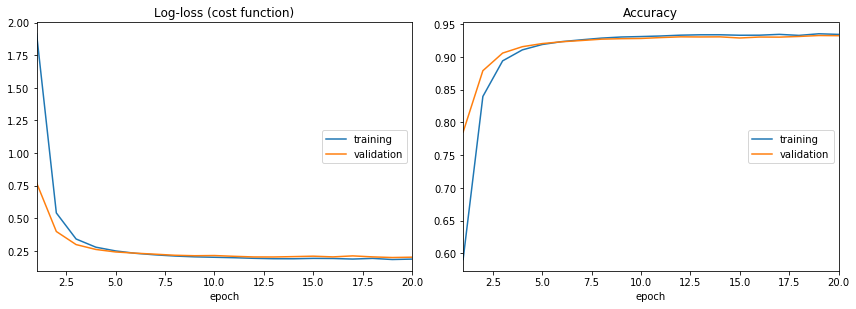

Log-loss (cost function):
training   (min:    0.184, max:    1.914, cur:    0.187)
validation (min:    0.199, max:    0.772, cur:    0.202)

Accuracy:
training   (min:    0.591, max:    0.935, cur:    0.934)
validation (min:    0.785, max:    0.932, cur:    0.932)
110288/110288 [==============================] - 10s 87us/step - loss: 0.1871 - acc: 0.9342 - val_loss: 0.2017 - val_acc: 0.9322
new jersey est parfois calme en l' automne et il est en en <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [25]:
def embed_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a RNN model using word embedding on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # Hyperparameters
    hidden_unit = 128  ## this is the numberof hidden units in GRU or LSTM
    latent_dim =  50  ##this is to reduce the dimension of the voacab size
    learning_rate = .01
    
    #print(input_shape)
    input_seq = Input(shape=(input_shape[1],)) ## without this comma this is just a integer 

    x = Embedding(english_vocab_size,latent_dim)(input_seq)
    x = GRU(hidden_unit,return_sequences = True )(x)
    logits = TimeDistributed(Dense(french_vocab_size))(x)
    
    model = Model(inputs = input_seq, outputs = Activation('softmax')(logits))
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model
tests.test_embed_model(embed_model)


# Reshape the input
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
#tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2]))

#tmp_x = pad(preproc_english_sentences,max_french_sequence_length)
#tmp_x = tmp_x.reshape((-1,preproc_french_sentences.shape[-2],1))




#print(tmp_x.shape)
#print('abcd')
# Train the neural network
embed_rnn_model = embed_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size+1,
    french_vocab_size+1)

embed_rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=1024, 
                        callbacks=[PlotLossesKeras()],epochs=20, validation_split=0.2)

# Print prediction(s)
print(logits_to_text(embed_rnn_model.predict(tmp_x[:1])[0], french_tokenizer))

### Model 3: Bidirectional RNNs (IMPLEMENTATION)
![RNN](images/bidirectional.png)
One restriction of a RNN is that it can't see the future input, only the past.  This is where bidirectional recurrent neural networks come in.  They are able to see the future data.

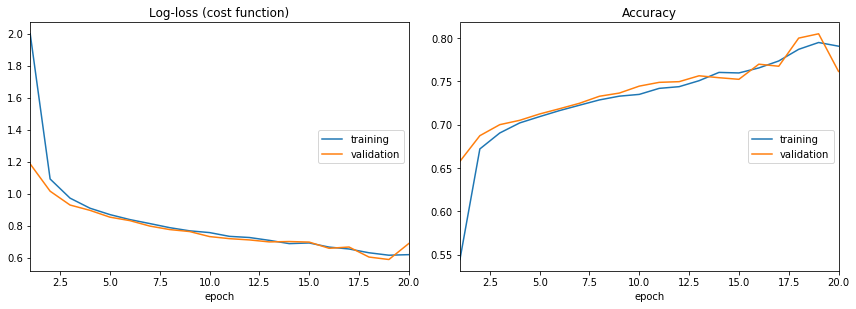

Log-loss (cost function):
training   (min:    0.615, max:    1.998, cur:    0.619)
validation (min:    0.589, max:    1.185, cur:    0.689)

Accuracy:
training   (min:    0.544, max:    0.795, cur:    0.791)
validation (min:    0.658, max:    0.805, cur:    0.762)
110288/110288 [==============================] - 14s 126us/step - loss: 0.6189 - acc: 0.7907 - val_loss: 0.6886 - val_acc: 0.7615
new jersey est parfois parfois au mois de il est est est en avril <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [22]:
def bd_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a bidirectional RNN model on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # Hyperparameters
    hidden_dim = 128
    learning_rate = .01
    
    input_seq = Input(shape = (input_shape[1], input_shape[2]))
    RNN_out = Bidirectional(GRU(hidden_dim,return_sequences = True))(input_seq)
    logits = TimeDistributed(Dense(french_vocab_size))(RNN_out)
    logits = Activation('sigmoid')(logits)
    
    model = Model(inputs= input_seq, outputs = logits)
    
    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = Adam(learning_rate), metrics = ['accuracy'])
    
    
    return model
tests.test_bd_model(bd_model)


# Train and Print prediction(s)
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))
#tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2]))

bidirectional_rnn_model = bd_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size+1,
    french_vocab_size+1)


bidirectional_rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=1024, 
                                callbacks=[PlotLossesKeras()],epochs=20, validation_split=0.2)

# Print prediction(s)
print(logits_to_text(bidirectional_rnn_model.predict(tmp_x[:1])[0], french_tokenizer))

### Model 4: Encoder-Decoder (OPTIONAL)
Time to look at encoder-decoder models.  This model is made up of an encoder and decoder. The encoder creates a matrix representation of the sentence.  The decoder takes this matrix as input and predicts the translation as output.

Create an encoder-decoder model in the cell below.

In [15]:
from livelossplot import PlotLossesKeras
def encdec_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train an encoder-decoder model on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # OPTIONAL: Implement
    french_maxlen = output_sequence_length
    hidden_dim = 128
    learning_rate = .01
    latent_dim = 128
    
    #encode_input_seq = Input(shape =(input_shape[1], input_shape[2]))
    # for LSTM  gru_enc_out,state_h, state_c = GRU(60,return_sequences= True, return_state = True )(encode_input_seq)
    #gru_enc_out,state_h = GRU(hidden_dim, return_state = True )(encode_input_seq)
    #encoder_state = [state_h]
                             
    #decoder_input_seq = Input(shape= (french_maxlen,1))
    #gru_dec_out, _ = GRU(hidden_dim,return_sequences = True, return_state = True)(decoder_input_seq,initial_state = encoder_state )
    #logits = TimeDistributed(Dense(french_maxlen))(gru_dec_out)
    #logits = Activation('sigmoid')(logits)
                             
    #model = Model(inputs = [encode_input_seq,decoder_input_seq],outputs =  logits)
    ##model = Model(inputs = encode_input_seq,outputs =  logits)
    
    
    ####
    encode_input_seq = Input(shape =(input_shape[1], input_shape[2]))
    gru_enc_out = GRU(hidden_dim)(encode_input_seq)
    enc_dense = Dense(latent_dim,activation = 'relu')(gru_enc_out)
    decoded = RepeatVector(french_maxlen)(enc_dense)  
    ##decoded = RepeatVector(1)(gru_enc_out)  
    print(decoded.shape)
    gru_dec_out = GRU(hidden_dim,return_sequences = True)(decoded)
    print(gru_dec_out.shape)
    logits = TimeDistributed(Dense(french_vocab_size))(gru_dec_out)
    logits = Activation('sigmoid')(logits)
                             
    model = Model(inputs = encode_input_seq,outputs =  logits)
    ######
                             
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model

tests.test_encdec_model(encdec_model)


# OPTIONAL: Train and Print prediction(s)
tmp_x = pad(preproc_english_sentences,max_english_sequence_length)
tmp_x = tmp_x.reshape(-1,preproc_english_sentences.shape[-1],1)
                             
#print(tmp_x.shape)
seq2seq_rnn_model = encdec_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size+1,
    french_vocab_size+1)

seq2seq_rnn_model.summary()


seq2seq_rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=1024, 
                          callbacks=[PlotLossesKeras()],epochs=20, validation_split=0.2)

Log-loss (cost function):
training   (min:    1.204, max:    3.378, cur:    1.249)
validation (min:    1.202, max:    2.806, cur:    1.246)

Accuracy:
training   (min:    0.406, max:    0.658, cur:    0.647)
validation (min:    0.409, max:    0.658, cur:    0.642)
110288/110288 [==============================] - 11s 97us/step - loss: 1.2488 - acc: 0.6465 - val_loss: 1.2461 - val_acc: 0.6422


In [ ]:
# Print prediction(s)
##print(logits_to_text(seq2seq_rnn_model.predict(tmp_x[:1])[0], french_tokenizer))

In [ ]:
## The below code show that we are not getting better result without using seq to seq model on this data.

#So we wont be using seq to seq model on this data. PLease 

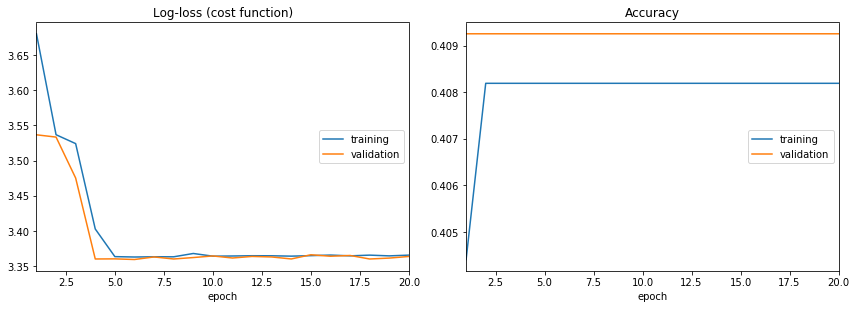

Log-loss (cost function):
training   (min:    3.363, max:    3.680, cur:    3.365)
validation (min:    3.359, max:    3.537, cur:    3.364)

Accuracy:
training   (min:    0.404, max:    0.408, cur:    0.408)
validation (min:    0.409, max:    0.409, cur:    0.409)
110288/110288 [==============================] - 21s 186us/step - loss: 3.3655 - acc: 0.4082 - val_loss: 3.3636 - val_acc: 0.4093


In [16]:
def model_not_final(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a model that incorporates embedding, encoder-decoder, and bidirectional RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """

    ##Hyperparameters
    learning_rate = .01
    embedding_dim = 50
    hidden_dim = 128
    max_french_len = output_sequence_length
    latent_dim = 128
    ##Model Config
    inp_seq = Input(shape= (input_shape[1],))
    embed_out = Embedding(english_vocab_size,embedding_dim)(inp_seq)
    gru_out   = Bidirectional(GRU(hidden_dim))(embed_out)
    enc_dense = Dense(latent_dim,activation = 'relu')(gru_out)
    decod_input = RepeatVector(max_french_len)(enc_dense)
    decod_gru_out = Bidirectional(GRU(hidden_dim,return_sequences= True))(decod_input)
    logits = TimeDistributed(Dense(french_vocab_size))(decod_gru_out)
    logits = Activation('sigmoid')(logits)
    
    ##Model Creation
    model = Model(inputs = inp_seq, outputs =logits)
    model.compile(loss ='sparse_categorical_crossentropy', 
                  optimizer = Adam(learning_rate), 
                  metrics = ['accuracy'])
    return model

tests.test_model_final(model_not_final)

tmp_x = pad(preproc_english_sentences,max_english_sequence_length)

model_not_final = model_not_final(tmp_x.shape, 
                          max_french_sequence_length, 
                          english_vocab_size+1, 
                          french_vocab_size+1)

print('This is NOT the final Model')
print('NOT Final Model Loaded')
# Train the final model

model_not_final.fit(preproc_english_sentences,preproc_french_sentences,
                    callbacks=[PlotLossesKeras()],batch_size =1024,epochs =20, validation_split = 0.2)

### Model 5: Custom (IMPLEMENTATION)
Use everything you learned from the previous models to create a model that incorporates embedding and a bidirectional rnn into one model.

In [14]:
def model_final(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    """
    Build and train a model that incorporates embedding, encoder-decoder, and bidirectional RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param french_vocab_size: Number of unique French words in the dataset
    :return: Keras model built, but not trained
    """
    # Hyperparameters
    hidden_unit = 128  ## this is the numberof hidden units in GRU or LSTM
    latent_dim =  50  ##this is to reduce the dimension of the voacab size
    learning_rate = .01
    
    #print(input_shape)
    input_seq = Input(shape=(input_shape[1:])) ## without this comma this is just a integer 

    x = Embedding(english_vocab_size,latent_dim)(input_seq)
    x = Bidirectional(GRU(hidden_unit,return_sequences = True ))(x)
    logits = TimeDistributed(Dense(french_vocab_size))(x)
    
    model = Model(inputs = input_seq, outputs = Activation('softmax')(logits))
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model

#tests.test_model_final(model_final)



print('THIS IS THE FINAL MODEL THAT WILL BE USED FOR PREDICTION')


# Reshape the input
#tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
#tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))
#tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2]))

#tmp_x = pad(preproc_english_sentences,max_french_sequence_length)
#tmp_x = tmp_x.reshape((-1,preproc_french_sentences.shape[-2],1))


#model_final = model_final(tmp_x.shape, 
#                          max_french_sequence_length, 
#                          english_vocab_size+1, 
#                          french_vocab_size+1)




THIS IS THE FINAL MODEL THAT WILL BE USED FOR PREDICTION


In [19]:
#from keras.models import load_model

#model_final.save('model_final.h5')  # creates a HDF5 file 'my_model.h5'

In [20]:
#from keras.models import load_model
#model = load_model('model_final.h5')

## Prediction (IMPLEMENTATION)

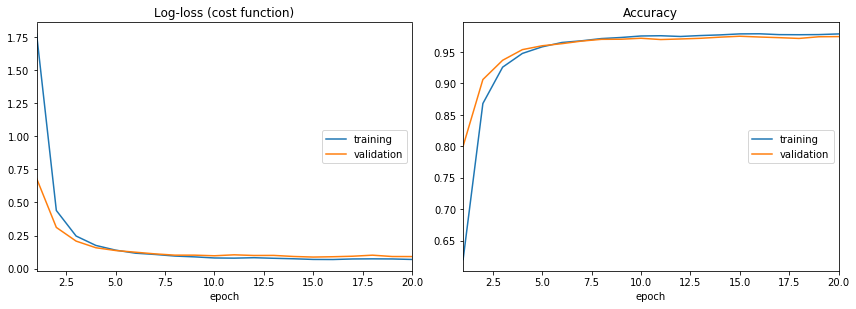

Log-loss (cost function):
training   (min:    0.069, max:    1.775, cur:    0.069)
validation (min:    0.087, max:    0.683, cur:    0.091)

Accuracy:
training   (min:    0.620, max:    0.979, cur:    0.979)
validation (min:    0.800, max:    0.975, cur:    0.975)
110288/110288 [==============================] - 15s 134us/step - loss: 0.0692 - acc: 0.9788 - val_loss: 0.0911 - val_acc: 0.9746
Sample 1:
il a vu un vieux camion jaune <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
Il a vu un vieux camion jaune
Sample 2:
new jersey est parfois calme pendant l' automne et il est neigeux en avril <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
new jersey est parfois calme pendant l' automne et il est neigeux en avril <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [15]:
from livelossplot import PlotLossesKeras
def final_predictions(x, y, x_tk, y_tk):
    """
    Gets predictions using the final model
    :param x: Preprocessed English data
    :param y: Preprocessed French data
    :param x_tk: English tokenizer
    :param y_tk: French tokenizer
    """
    # Train neural network using model_final
    # Reshape the input
    #print(max, max([len(french_sentences) for french_sentences in y]))
    tmp_x = pad(x, max([len(french_sentences) for french_sentences in y]))
    tmp_x = tmp_x.reshape((-1, y.shape[-2]))
    

    model = model_final(tmp_x.shape, y.shape[1], 
                          len(x_tk.word_index)+1, 
                          len(y_tk.word_index)+1)
    
    model.summary()
    
    model.fit(tmp_x, y, batch_size=1024, 
                        callbacks=[PlotLossesKeras()],epochs=20, validation_split=0.2)

    
    ## DON'T EDIT ANYTHING BELOW THIS LINE
    y_id_to_word = {value: key for key, value in y_tk.word_index.items()}
    y_id_to_word[0] = '<PAD>'

    sentence = 'he saw a old yellow truck'
    sentence = [x_tk.word_index[word] for word in sentence.split()]
    ##sentence = pad_sequences([sentence], maxlen=x.shape[-1], padding='post')
    ## Padding english sentences for the maximum french setences length
    sentence = pad_sequences([sentence], maxlen=y.shape[-2], padding='post')
    ###print(sentence[0],'abcd',x[0],x.shape)
    sentences = np.array([sentence[0], tmp_x[0]])
    #print(sentences)
    #####print(sentences.shape)

    predictions = model.predict(sentences, len(sentences))

    print('Sample 1:')
    print(' '.join([y_id_to_word[np.argmax(x)] for x in predictions[0]]))
    print('Il a vu un vieux camion jaune')
    print('Sample 2:')
    print(' '.join([y_id_to_word[np.argmax(x)] for x in predictions[1]]))
    print(' '.join([y_id_to_word[np.max(x)] for x in y[0]]))


final_predictions(preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer)